# Requiremnts

In [ ]:
data = '/content/drive/MyDrive/Major Project/data/'

In [ ]:
! pip install pmdarima
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from dateutil.parser import parse
%matplotlib inline
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from datetime import timedelta
from pmdarima.arima import auto_arima
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
pd.set_option('mode.use_inf_as_na',True)
def getModel( y , X = None, verbose = True):
    model = pm.auto_arima( X = X, y = y , start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=14, max_q=5, # maximum p and q
                      m=1,              # frequency of series 1 for non seasonal data
                      d=None,           # let model determine 'd'
                      max_d = 5,        # by default 2 (only!)
                      seasonal=False,   # No Seasonality
                      trace = verbose,
                      suppress_warnings=True, 
                      stepwise=True,
                      maxiter = 100
                      )
    # if verbose:
    #     print(model.summary())

    return model

def forecast(model, X = None, period = 60, field = 'Daily Confirmed'):
    
    fc, confint = model.predict( X = X, n_periods=period , return_conf_int=True)
    # index_of_fc = [start_date + timedelta(days) for days in range(period)]

    # make series for plotting purpose
    fc_series = pd.Series(fc)
    # fc_series.rename(field, inplace=True)
    # lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    # upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    # plt.figure(figsize=(16, 5))
    # plt.plot(cleaned[field])
    # plt.plot(fc_series, color='darkgreen')
    # plt.fill_between(lower_series.index, 
    #                 lower_series, 
    #                 upper_series, 
    #                 color='k', alpha=.15)
    # plt.title(f"Final Forecast of {field} for {period} days")
    # plt.show()
    return fc_series

     |████████████████████████████████| 1.5MB 12.2MB/s 
     |████████████████████████████████| 9.5MB 44.9MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# Extracting CSV

In [ ]:
cleaned =  pd.read_csv(os.path.join(data, 'central_data/cleaned.csv'), parse_dates=[0])
cleaned.drop(columns=['public_information_campaigns', 'testing_policy', 'vaccination_policy', 'total_vaccinations', 'Total Confirmed', 'Daily Recovered','Total Recovered', 'Total Deceased','close_public_transport',
       'cancel_public_events','facial_coverings','people_vaccinated', 'people_fully_vaccinated', 'stay_home_requirements'], inplace=True)
# cleaned = cleaned[['Day','Daily Confirmed']]
# cleaned['percentage_change'] = cleaned['Daily Confirmed'].pct_change()
cleaned['mobility_driving'].ffill(inplace=True)
cleaned['mobility_walking'].ffill(inplace=True)
cleaned.fillna(0,inplace=True)
cleaned.columns

Index(['Day', 'stringency_index', 'mobility_driving', 'mobility_walking',
       'retail_and_recreation', 'grocery_and_pharmacy', 'residential',
       'transit_stations', 'parks', 'workplaces', 'Daily Confirmed',
       'Daily Deceased'],
      dtype='object')

# Functions to get regression model and check impact of lockdown

In [24]:
def get_lagged(df=cleaned,n=14):
  lag_variables  = ['Daily Confirmed','Daily Deceased','stringency_index', 'mobility_driving','mobility_walking', 'retail_and_recreation', 'grocery_and_pharmacy','residential', 'transit_stations', 'parks', 'workplaces']
  # lag_variables  = ['Daily Confirmed']
  lags = range(1,n+1)
  for lag in lags:
    new_df = df.copy()
    new_df.Day += timedelta(lag)
    new_df = new_df[['Day']+lag_variables]
    new_df.columns = ['Day']+ [lag_feat +'_lag_'+str(lag) for lag_feat in lag_variables]
    df = pd.merge( df, new_df, on=['Day'], how='left')
    del new_df

  df.fillna(0, inplace=True)
  cols = df.columns
  for col in cols:
    if col in lag_variables:
      df.drop(columns=col, inplace=True)
  return df

def tester(clean, n):
  clean2 = clean.copy()
  final = get_lagged(clean,n)
  # final = clean.copy()
  for cols in clean.columns[2:-2]:
    clean2[cols] -= 0.75*abs(clean2[cols])
  # clean2['stringency_index'] = 0.75*clean2['stringency_index']
  final2 = get_lagged(clean2,n)
  # final2 = clean2.copy()
  X_train = final.drop(final.tail(55).index)
  X_test1 = final.tail(55)
  X_test2 = final2.tail(55)
  X_train.drop(columns=['Day'], inplace=True)
  # X_train.drop(columns=['Day', 'Daily Confirmed'], inplace=True)
  X_test1.drop(columns=['Day'], inplace=True)
  # X_test1.drop(columns=['Day','Daily Confirmed'], inplace=True)
  X_test2.drop(columns=['Day'], inplace=True)
  # X_test2.drop(columns=['Day','Daily Confirmed'], inplace=True)
  y_train = cleaned['Daily Confirmed'].head(-55)
  y_test = cleaned['Daily Confirmed'].tail(55)
  linreg = LinearRegression().fit(X_train, y_train)
  print('linear model coeff (w): {}'.format(linreg.coef_))
  print('rmse score (training): {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_train, linreg.predict(X_train)))))
  print('R-squared score (training): {:.3f}'.format(linreg.score(X_train, y_train)))
  print('rmse score (test): {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, linreg.predict(X_test1)))))
  print('R-squared score (test): {:.3f}'.format(linreg.score(X_test1, y_test)))
  y_pred = linreg.predict(X_test1)
  plt.figure(figsize=(10, 10))
  # plt.plot(final['Day'].head(-55), y_train, label = 'First Wave')
  plt.plot(final['Day'].tail(55),y_test, color='green', label= 'Second Wave')
  # plt.plot(final['Day'].tail(55),linreg.predict(X_test1), color='red', label='predicted Second Wave')
  plt.plot(final['Day'].tail(55),linreg.predict(X_test2), label='Lockdown Impact on second wave')
  plt.legend()
  plt.show()
  return linreg

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


linear model coeff (w): [ 5.32827907e-01  8.26031693e-01  1.39515936e+01  7.13244510e+01
 -6.82247874e+01 -6.14309729e+01  7.53708667e+01 -6.44147070e+02
 -2.43885779e+03  2.82415125e+02  1.87142146e+03  1.47935869e-01
  7.52208279e-01  3.49814732e+01  2.37897194e+01 -5.22104017e+00
 -1.88196555e+02 -2.39941289e+02  1.91251035e+03  3.62967850e+03
  1.85118620e+01 -2.49489191e+03  1.71797932e-01  2.95690045e-01
 -6.14293787e+01 -1.71530194e+01 -1.67900477e+00 -8.66707968e+02
 -2.73709675e+02 -2.39542110e+03 -1.37690905e+02 -3.49842795e+01
  3.98869285e+02  4.60484298e-02 -1.01784689e+00 -1.09398977e+01
 -5.02809848e+00  2.16278176e+01  1.79945271e+03  4.05065999e+02
  1.22304724e+03 -1.49373425e+03 -8.60819471e+02  4.45964116e+02
 -2.39757521e-03 -1.33188634e+00 -1.61334327e+01 -1.42779301e+01
 -2.06666082e+00 -1.07907177e+03 -5.21197589e+01 -9.56730952e+02
  1.36719635e+03  4.52072354e+02 -7.27582318e+02  7.79634531e-02
 -1.28701661e+00  1.26018746e+02  8.10370769e+01 -7.26431254e+01
 

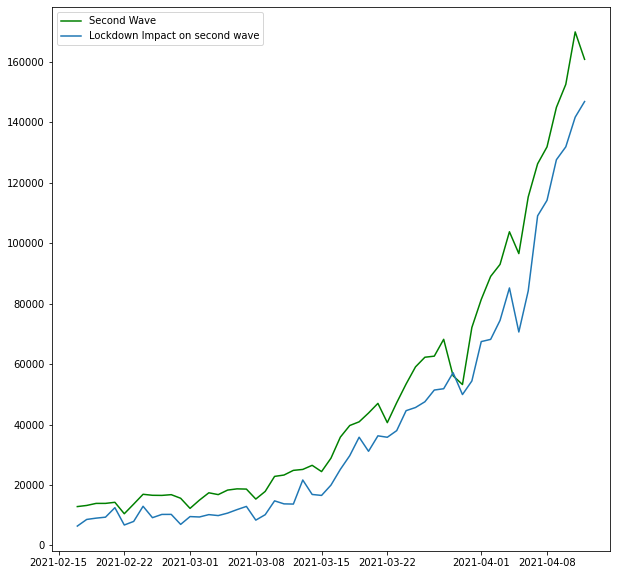

In [25]:
lag14_linreg = tester(cleaned,10)